# Tagging of Bees and Data Quality (checking against the age of bees)

In [111]:
import networkx as nx
import os
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import datetime
import pytz
import matplotlib.pyplot as plt
import preprocessing as prep
from collections import namedtuple
from bb_binary import FrameContainer, Repository, load_frame_container
import numpy as np
import numpy.ma as npma
import datetime
import csv
import seaborn as sns
from collections import Counter

In [2]:
%matplotlib inline

In [3]:
Detection = namedtuple('Detection', ['idx', 'xpos', 'ypos', 'radius', 'zRotation', 'decodedId', 'frame_idx', 'timestamp', 'cam_id', 'fc_id'])

In [4]:
def getDF(path, b, e, camID):
    repo = Repository(path)
    
    tpls = []
    myid = 0


    for frame, fc in repo.iter_frames(begin=b, end=e, cam=camID):
        for d in frame.detectionsUnion.detectionsDP:
            d = Detection(d.idx, d.xpos, d.ypos, d.radius, d.zRotation, list(d.decodedId), myid, frame.timestamp, fc.camId, fc.id)
            tpls.append(d)
        myid += 1

    df = DataFrame(tpls)
    return df

# Dateset: 2016 21.07. 15:00 Uhr (5 Minutes)

In [876]:
start = "2016-07-21T15:00:00Z"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
start_ts = start_dt.timestamp()
end_dt = start_dt + datetime.timedelta(minutes=5)
end_ts = end_dt.timestamp()

In [877]:
df3 = getDF("/mnt/data2016/",start_ts, end_ts, 3)

In [878]:
len(df3.frame_idx.unique())/3/60

5.016666666666667

In [879]:
len(df3.frame_idx.unique())

903

In [880]:
df2 = getDF("/mnt/data2016/",start_ts, end_ts, 2)

In [881]:
len(df2.frame_idx.unique())

874

In [882]:
len(df2.frame_idx.unique())/3/60

4.855555555555555

In [883]:
df1 = getDF("/mnt/data2016/",start_ts, end_ts, 1)

In [884]:
len(df1.frame_idx.unique())/3/60

5.016666666666667

In [885]:
df0 = getDF("/mnt/data2016/",start_ts, end_ts, 0)

In [886]:
len(df0.frame_idx.unique())/3/60

5.016666666666667

# Overview of Tagged Bees

In [206]:
csvdata = pd.read_csv("hatchdates2016.csv")

In [207]:
csvdata.head(2)

,dec12,dec9,birthdate,later tagged
0,0,0,NaN,NaN
1,1,256,28.07.2016,NaN


## Number of tagged bees

In [208]:
len(csvdata.birthdate.dropna())

3181

In [209]:
len(csvdata['later tagged'].dropna())

10

In [210]:
csvdata = csvdata.fillna(0)

In [211]:
csvdata.loc[csvdata['birthdate']==0, 'birthdate'] = csvdata['later tagged']

In [212]:
csvdata = csvdata.iloc[:, :-1]

In [213]:
datesCSV = csvdata.birthdate

In [214]:
datesCSV = datesCSV[datesCSV != 0]

In [215]:
datesCSV = datesCSV.apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y").replace(tzinfo=pytz.UTC))
datesCSV = datesCSV.map(lambda t: t.strftime('%Y-%m-%d'))

In [216]:
datesCSV.head()

1    2016-07-28
2    2016-08-03
3    2016-07-06
4    2016-08-22
5    2016-07-14
Name: birthdate, dtype: object

## First day of tagging and last day of tagging

In [217]:
datesCSV.min()

'2016-06-28'

In [218]:
datesCSV.max()

'2016-09-02'

## Tagging Frequency (PLOT)

In [219]:
dateDF = DataFrame(datesCSV.value_counts())

In [220]:
dateDF.head()

,birthdate
2016-07-01,155
2016-08-11,154
2016-07-21,149
2016-07-28,148
2016-07-20,132


In [221]:
index = pd.date_range(datesCSV.min(), datesCSV.max(), freq='D')
index = index.map(lambda t: t.strftime('%Y-%m-%d'))

In [222]:
df_i = DataFrame(index=index)

In [223]:
df_i.head()

""
2016-06-28
2016-06-29
2016-06-30
2016-07-01
2016-07-02


In [224]:
res = pd.concat([df_i, dateDF], axis=1)

In [225]:
res = res.fillna(0)

In [226]:
res.describe()

,birthdate
count,67.000000
mean,47.626866
std,58.427328
min,0.000000
25%,0.000000
50%,1.000000
75%,118.500000
max,155.000000


In [268]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 10.
mpl.rcParams['axes.labelsize'] = 8.
mpl.rcParams['xtick.labelsize'] = 6.
mpl.rcParams['ytick.labelsize'] = 6.

In [269]:
sns.set_context("paper")

In [231]:
res.head()

,birthdate
2016-06-28,118.0
2016-06-29,96.0
2016-06-30,65.0
2016-07-01,155.0
2016-07-02,0.0


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Roboto'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


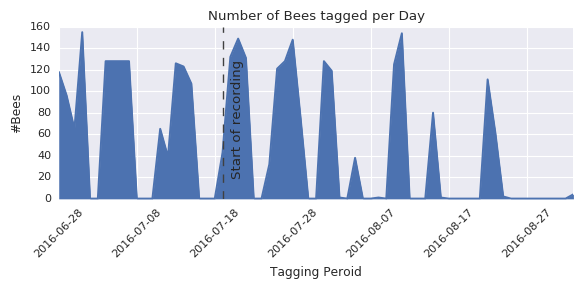

In [911]:
fig, ax = plt.subplots()
res.plot.area(legend=False, ax=ax)
ax.set_title("Number of Bees tagged per Day")
ax.set_ylabel("#Bees")
ax.set_xlabel("Tagging Peroid")
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=45)
fig.set_size_inches(5.91553,3)
plt.axvline(21, color='0.25', linestyle='dashed', linewidth=1)
plt.text(22.1,120,'Start of recording',rotation=90)
plt.tight_layout()
plt.savefig('tagging_period.pdf')

# Wo ist genau die Hälfte getagged worden an welchem Tag?

In [492]:
res.head()

,birthdate
2016-06-28,118.0
2016-06-29,96.0
2016-06-30,65.0
2016-07-01,155.0
2016-07-02,0.0


In [511]:
res[res.birthdate > 0].birthdate.describe()

count     35.000000
mean      91.171429
std       50.397529
min        1.000000
25%       52.000000
50%      118.000000
75%      128.000000
max      155.000000
Name: birthdate, dtype: float64

In [480]:
total = res.birthdate.sum()/2

In [481]:
total

1595.5

In [487]:
cumm = 0
for d,bday in res.iterrows():
    cumm += bday[0]
    if cumm >= total:
        print(d)
        break

2016-07-21


# Testing the Confidence - Evaluation Confidence

* 5 Minuten Datensatz
* detections mit confidence filtern (0.02er Schritte)
* abgleichen mit Geburtsdatum

In [299]:
import hatching as ht

In [586]:
np.arange(0,1.02,0.02)

array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
        0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
        0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
        0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,
        0.72,  0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,
        0.9 ,  0.92,  0.94,  0.96,  0.98,  1.  ])

In [713]:
def get_all_bees_age(datum):
    # Input: date object
    # Output: pandas dataframe
    if isinstance(datum, datetime.datetime):
        datum = datum.date()
    
    ages = []
    
    f = pd.read_csv('hatchdates2016.csv')
    f = f[[0,2]]
    f = f.fillna('')
    f.birthdate = f.birthdate.apply(lambda x: ht.str_to_datetime(x))
    f['age'] = f.birthdate.apply(lambda x: (datum - x.date()))
    f.age.fillna(-1, inplace = True)
    f.age = f.age.apply(lambda x: x.days)
    return f

In [714]:
aa = get_all_bees_age(start_dt)

In [715]:
aa.head()

,dec12,birthdate,age
0,0,NaT,-1
1,1,2016-07-28,-7
2,2,NaT,-1
3,3,2016-07-06,15
4,4,2016-08-22,-32


In [914]:
def testQuality(df, start_dt, name, sampleSize=100000):
    
    aa = get_all_bees_age(start_dt)
    
    quality = []

    for i in [0.95]:
        ids = prep.calcIds(df, i, 2016)
        total = df.shape[0]
        rows = ids.shape[0] # total detections with confidence

        ids_sample = ids.sample(sampleSize)
        #ids_sample = ids
        ids_sample["age"] = ids_sample.id.apply(lambda x: aa.iloc[x].age)
        age = ids_sample.age

        ageWrong = len(age[age < 0])
        ageRight = len(age[age >= 0 ])

        quality.append((i, ageWrong, ageRight, rows, total, sampleSize))
        print(".", end='')
    
    qualityDF = DataFrame(quality, columns=['confidence', 'wrong', 'right', 'rows', 'total', 'sampleSize'])
    qualityDF.to_pickle('qualityDF-{}.pickle'.format(name))
    return qualityDF

In [915]:
q95 = testQuality(dfall, start_dt, "all cameras")

.

## For 0.95 Confidence

In [918]:
q95

,confidence,wrong,right,rows,total,sampleSize,wrong2,wrong2p,rowsp,c
0,0.95,3044,96956,269138,455090,100000,6088,6.088,59.139511,95.0


In [917]:
q95['wrong2'] = q95.wrong*2
q95['wrong2p'] = 100*q95.wrong2/q95.sampleSize
q95['rowsp'] = 100*q95.rows/q95.total
q95['c'] = q95.confidence *100 

In [ ]:
np.arange(0,1.02,0.02)

In [888]:
dfall = pd.concat([df0,df1,df2,df3])

In [903]:
q = testQuality(dfall, start_dt, "all cameras")

...................................................

In [904]:
q.head()

,confidence,wrong,right,rows,total,sampleSize
0,0.00,18001,81999,455090,455090,100000
1,0.02,16893,83107,445213,455090,100000
2,0.04,16472,83528,439454,455090,100000
3,0.06,15582,84418,431842,455090,100000
4,0.08,15171,84829,427285,455090,100000


In [949]:
def plotConfidenc(q, text):
    
    fig, ax = plt.subplots()
    q['wrong2'] = q.wrong*2
    q['wrong2p'] = 100*q.wrong2/q.sampleSize
    q['rowsp'] = 100*q.rows/q.total
    q['c'] = q.confidence *100 
    ax = q.plot(x='c', y=['rowsp', 'wrong2p'], stacked=False, kind='area', alpha=0.75, ax=ax, colormap='summer')
    ax.set_title('Tradeoff: confidence, wrong detection, \n and amount of data ({})'.format(text))
    ax.set_xlabel('Confidence in %')
    ax.set_ylabel('Amount of data in %')
    ax.legend(['Remaining data', 'Wrong detections'])
    # Confidence
    plt.axvline(95, color='0.25', linestyle='dashed', linewidth=1)
    plt.text(88,20,'95%',rotation=0)
    # Data 59.139511
    plt.axhline(59.139511, color='0.25', linestyle='dotted', linewidth=1)
    plt.text(5,61,'~59%',rotation=0)
    # Error 6.088
    plt.axhline(6.0881, color='0.25', linestyle='dotted', linewidth=1)
    plt.text(5,8,'~6%',rotation=0)
    fig.set_size_inches(5.91553,4)
    plt.tight_layout()
    print(q[q.confidence >= 0.8])
    plt.savefig('tradeoff.pdf')

    confidence  wrong  right    rows   total  sampleSize  wrong2  wrong2p  \
40        0.80   4850  95150  316873  455090      100000    9700    9.700   
41        0.82   4656  95344  312269  455090      100000    9312    9.312   
42        0.84   4436  95564  308822  455090      100000    8872    8.872   
43        0.86   4126  95874  303212  455090      100000    8252    8.252   
44        0.88   4054  95946  298988  455090      100000    8108    8.108   
45        0.90   3712  96288  291640  455090      100000    7424    7.424   
46        0.92   3505  96495  285679  455090      100000    7010    7.010   
47        0.94   3052  96948  274063  455090      100000    6104    6.104   
48        0.96   2805  97195  263330  455090      100000    5610    5.610   
49        0.98   2345  97655  234008  455090      100000    4690    4.690   
50        1.00   1785  98215  165339  455090      100000    3570    3.570   

        rowsp      c  
40  69.628645   80.0  
41  68.616977   82.0  
42  67

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Roboto'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


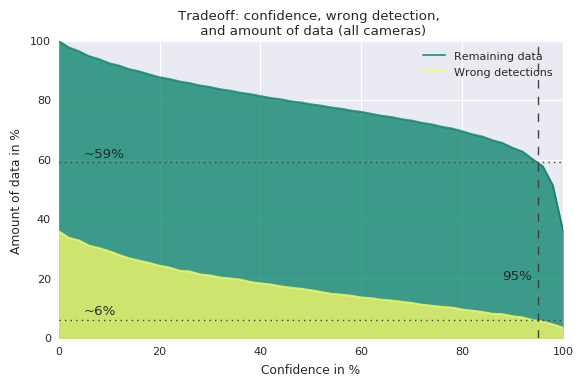

In [950]:
plotConfidenc(q, 'all cameras')